In [26]:
import sys
from pathlib import Path
project_root = Path().cwd().resolve().parent
sys.path.insert(0, str(project_root))

In [27]:
import sqlite3

import os, argparse, path_config, shutil
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from loguru import logger

import torch
from torch_geometric.utils import to_networkx
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import torch.nn.functional as F

from graph._multimodal_model_bilstm.GAT import GATClassifier as BiLSTMGAT, GATJKClassifier as BiLSTMV2GAT
from graph._multimodal_model_no_bilstm.GAT import GATClassifier as NoBiLSTMGAT, GATJKClassifier as NoBiLSTMV2GAT
from graph._unimodal_model.GAT import GATClassifier as UniGAT, GATJKClassifier as UniV2GAT
from graph._bimodal_model_bilstm.GAT import GATClassifier as BiGAT, GATJKClassifier as BiV2GAT

from graph.multimodal_bilstm.dataset import make_graph as BiLSTM_make_graph
from graph.multimodal_proxy.dataset import make_graph as Proxy_make_graph
from graph.multimodal_topic_bilstm.dataset import make_graph as TopicBiLSTM_make_graph
from graph.multimodal_topic_bilstm_proxy.dataset import make_graph as TopicProxyBiLSTM_make_graph
from graph.multimodal_topic_proxy.dataset import make_graph as TopicProxy_make_graph
from graph.unimodal_topic.dataset import make_graph as UniTopic_make_graph
from graph.bimodal_topic_bilstm_proxy.dataset import make_graph as BiTopicProxy_make_graph

plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False

In [28]:
logger.remove()
logger.add(
  sys.stdout,
  colorize=True,
  format="<green>{time:HH:mm:ss}</green> | <level>{level: <8}</level> | <level>{message}</level>",
)

MODEL = {
  'multimodal_bilstm':BiLSTMGAT,
  'multimodal_proxy':NoBiLSTMGAT,
  'multimodal_topic_bilstm':BiLSTMGAT,
  'multimodal_topic_bilstm_proxy':BiLSTMGAT,
  'multimodal_topic_proxy':NoBiLSTMGAT,
  'unimodal_topic':UniGAT,
  'bimodal_topic_bilstm_proxy':BiGAT
}

V2_MODEL = {
  'multimodal_bilstm':BiLSTMV2GAT,
  'multimodal_proxy':NoBiLSTMV2GAT,
  'multimodal_topic_bilstm':BiLSTMV2GAT,
  'multimodal_topic_bilstm_proxy':BiLSTMV2GAT,
  'multimodal_topic_proxy':NoBiLSTMV2GAT,
  'unimodal_topic':UniV2GAT,
  'bimodal_topic_bilstm_proxy':BiV2GAT
}

MAKE_GRAPH = {
  'multimodal_bilstm':BiLSTM_make_graph,
  'multimodal_proxy':Proxy_make_graph,
  'multimodal_topic_bilstm':TopicBiLSTM_make_graph,
  'multimodal_topic_bilstm_proxy':TopicProxyBiLSTM_make_graph,
  'multimodal_topic_proxy':TopicProxy_make_graph,
  'unimodal_topic':UniTopic_make_graph,
  'bimodal_topic_bilstm_proxy':BiTopicProxy_make_graph
}

In [29]:
def fetch_from_db(db_path):
  con = sqlite3.connect(db_path)
  cursor = con.cursor()
  cursor.execute('''
    SELECT param_name, param_value 
    FROM trial_params
    WHERE trial_id = (
      SELECT trial_id
      FROM trial_values
      ORDER BY value DESC
      LIMIT 1
    );
  ''')
  best_hyperparams_list = cursor.fetchall()
  best_hyperparams_dict = {}

  for k, v in best_hyperparams_list:
    if k not in ['batch_size', 'focal_alpha', 'focal_gamma', 'lr', 'optimizer', 'weight_decay']:
      if k in ['use_text_proj', 'use_attention']:
        best_hyperparams_dict[k] = True if v==0.0 else False
      elif k in ['num_layers', 'bilstm_num_layers']:
        best_hyperparams_dict[k] = int(v)
      else:
        best_hyperparams_dict[k] = v

  cursor.execute('''
    SELECT value
    FROM trial_values
    ORDER BY value DESC
    LIMIT 1
  ''')
  best_f1 = cursor.fetchone()[0]
  
  return best_hyperparams_dict, best_f1

In [30]:
model_dir = 'checkpoints_optuna'
model_dir_ = 'multimodal_topic_bilstm_proxy_v2'
save_dir = 'graph_visualization'
save_dir_ = 'multimodal_topic_bilstm_proxy_v2_id_384'
id = 405
mode = 'multimodal_topic_bilstm_proxy'
version = 2

best_model_path = os.path.join(path_config.ROOT_DIR, model_dir, model_dir_, 'best_model.pth')
db_path = os.path.join(path_config.ROOT_DIR, model_dir, model_dir_, 'logs', 'optuna_study.db')
assert os.path.exists(best_model_path) and os.path.exists(db_path), logger.error("Model path is wrong. Try again.")

In [31]:
logger.info(f"Processing data (Mode: {mode}, Id: {id})")

if "multimodal" in mode:
  logger.info(f"Doing with multimodal mode")
  graphs, dim_list, extras = MAKE_GRAPH[mode](
    ids = [id],
    labels = [1],                   # Temporary Label
    model_name = 'sentence-transformers/all-MiniLM-L6-v2',
    use_summary_node = True,
    t_t_connect = False,
    v_a_connect = False,
    explanation = True
  )

  t_dim = dim_list[0]
  v_dim = dim_list[1]
  a_dim = dim_list[2]

else:
  logger.info(f"Doing with non-multimodal mode")
  graphs, dim_list, extras = MAKE_GRAPH[mode](
    ids = [id],
    labels = 1,                   # Temporary Label
    model_name = 'sentence-transformers/all-MiniLM-L6-v2',
    use_summary_node = True,
    t_t_connect = False,
    explanation = True
  )

  t_dim = dim_list[0]
  if 'bimodal' in mode:
    v_dim = dim_list[1]

01:05:02 | INFO     | Processing data (Mode: multimodal_topic_bilstm_proxy, Id: 405)
01:05:02 | INFO     | Doing with multimodal mode
01:05:02 | INFO     | Getting your model
01:05:05 | INFO     | Model loaded
01:05:05 | INFO     | Switching CSV into Graphs


Dataframe -> Graph: 100%|██████████| 1/1 [00:02<00:00,  2.99s/it]


In [32]:
topic_node_id, utterances, vision_input, audio_input = extras

best_hyperparams_dict, best_f1 = fetch_from_db(db_path)

logger.info(f"Best Params")
for k, v in best_hyperparams_dict.items():
  logger.info(f"  - {k}: {v}")
logger.info(f"=> F1-score: {best_f1}")

01:05:08 | INFO     | Best Params
01:05:08 | INFO     |   - a_dropout: 0.39294858998728843
01:05:08 | INFO     |   - bilstm_num_layers: 2


01:05:08 | INFO     |   - g_dropout: 0.24654580705928375
01:05:08 | INFO     |   - num_layers: 3
01:05:08 | INFO     |   - t_dropout: 0.25237807640094945
01:05:08 | INFO     |   - use_attention: True
01:05:08 | INFO     |   - use_text_proj: False
01:05:08 | INFO     |   - v_dropout: 0.3430548105111857
01:05:08 | INFO     | => F1-score: 0.7586206896551724


In [33]:
logger.info("==============================")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
logger.info(f"Loading your model (Device: {device})")

assert version in [1,2], logger.error("Version should be int type 1 or 2")

if version == 1:
  model_dict = MODEL
elif version == 2:
  model_dict = V2_MODEL

dropout_dict = {
  'text_dropout':best_hyperparams_dict.get('t_dropout', 0.0),
  'graph_dropout':best_hyperparams_dict.get('g_dropout', 0.0),
  'vision_dropout':best_hyperparams_dict.get('v_dropout', 0.0),
  'audio_dropout':best_hyperparams_dict.get('a_dropout', 0.0)
}

if "unimodal" in mode:
  model = model_dict[mode](
    text_dim=t_dim,
    hidden_channels=256 if best_hyperparams_dict['use_text_proj'] else t_dim,
    num_layers=best_hyperparams_dict['num_layers'],
    num_classes=2,
    dropout_dict=dropout_dict,
    heads=8,
    use_summary_node=True,
    use_text_proj=best_hyperparams_dict['use_text_proj']
  ).to(device)
elif "bimodal" in mode:
  model = model_dict[mode](
    text_dim=t_dim,
    vision_dim=v_dim,
    hidden_channels=256 if best_hyperparams_dict['use_text_proj'] else t_dim,
    num_layers=best_hyperparams_dict['num_layers'],
    bilstm_num_layers=best_hyperparams_dict['bilstm_num_layers'],
    num_classes=2,
    dropout_dict=dropout_dict,
    heads=8,
    use_attention=best_hyperparams_dict['use_attention'],
    use_summary_node=True,
    use_text_proj=best_hyperparams_dict['use_text_proj']
  ).to(device)
else:
  if 'bilstm' in mode:
    model = model_dict[mode](
      text_dim=t_dim,
      vision_dim=v_dim,
      audio_dim=a_dim,
      hidden_channels=256 if best_hyperparams_dict['use_text_proj'] else t_dim,
      num_layers=best_hyperparams_dict['num_layers'],
      bilstm_num_layers=best_hyperparams_dict['bilstm_num_layers'],
      num_classes=2,
      dropout_dict=dropout_dict,
      heads=8,
      use_attention=best_hyperparams_dict['use_attention'],
      use_summary_node=True,
      use_text_proj=best_hyperparams_dict['use_text_proj']
    ).to(device)
  else:
    model = model_dict[mode](
      text_dim=t_dim,
      vision_dim=v_dim,
      audio_dim=a_dim,
      hidden_channels=256 if best_hyperparams_dict['use_text_proj'] else t_dim,
      num_layers=best_hyperparams_dict['num_layers'],
      num_classes=2,
      dropout_dict=dropout_dict,
      heads=8,
      use_summary_node=True,
      use_text_proj=best_hyperparams_dict['use_text_proj']
    ).to(device)

best_model_state_dict = torch.load(best_model_path)
model.load_state_dict(best_model_state_dict)

01:05:08 | INFO     | ==============================
01:05:08 | INFO     | Loading your model (Device: cuda)


<All keys matched successfully>

In [34]:
sample_loader = DataLoader(graphs)

model.eval()
with torch.no_grad():
  for data in sample_loader:
    data = data.to(device)
    result, x, flat_node_types = model(data, explanation=True)
    x = x.cpu()
    y = torch.tensor([torch.sigmoid(result) > 0.5], dtype=torch.long)
y

tensor([1])

In [35]:
topic_node_id

{'개인 특성 및 경험': 0, '대인 관계 및 가족': 1, '생활 환경 및 취미': 2, '심리 상태 및 감정': 3}

In [36]:
topic_summary_indices = [i for i, t in enumerate(flat_node_types) if t == 'topic' or t=='summary']
topic_summary_node_type = [t for t in flat_node_types if t=='topic' or t=='summary']
topic_summary_x = x[topic_summary_indices]
source_data = [i for i in range(1, len(topic_summary_x))]
target_data = [0 for i in range(1, len(topic_summary_x))]
edge_index = torch.tensor([source_data, target_data], dtype=torch.long)
topic_summary_data = Data(x=topic_summary_x, edge_index=edge_index, y=y, node_types=topic_summary_node_type)
topic_node_dict = {v+1:str(k) for k,v in topic_node_id.items()}

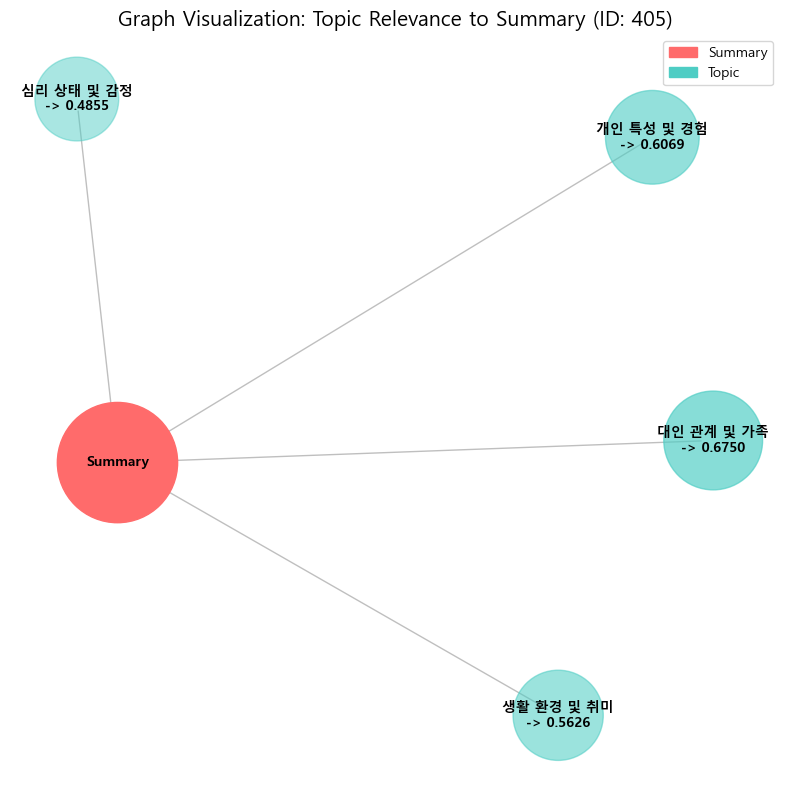

In [39]:
summary_vec = topic_summary_x[0].unsqueeze(0)
topic_vecs = topic_summary_x[1:]

# Summary 노드와의 코사인 유사도
similarities = F.cosine_similarity(summary_vec, topic_vecs)

scale_factor = 7500
topic_sizes = (similarities.detach().numpy() * scale_factor)

node_sizes = [7500] + topic_sizes.tolist()

similarity_list = similarities.detach().numpy().tolist()
node_values = [1.0] + similarity_list

sample_graph = topic_summary_data
color_map = {
    'summary': '#FF6B6B',      # 빨강
    'topic': '#4ECDC4',        # 청록
  }
node_colors = [color_map.get(node_type, 'gray') for node_type in sample_graph.node_types]
G = to_networkx(sample_graph, to_undirected=False)
node_labels = {}
idx = 0
if sample_graph.node_types[0] == 'summary':
  node_labels[idx] = 'Summary'
  idx += 1

for i in range(idx, len(topic_summary_x)):
  node_labels[idx] = f"{topic_node_dict[i]}\n-> {similarity_list[i-1]:.4f}"
  idx += 1

plt.figure(figsize=(8, 8))
pos = nx.spring_layout(G, k=0.5)

nx.draw_networkx_nodes(G, pos,
                      node_color=node_colors,
                      node_size=node_sizes,
                      alpha=node_values)
nx.draw_networkx_edges(G, pos, edge_color='gray',
                      arrows=True, arrowstyle='->', arrowsize=20,
                      width=1.0, alpha=0.5)
nx.draw_networkx_labels(G, pos,
                      labels=node_labels,
                      font_size=10,
                      font_weight='bold',
                      font_family='Malgun Gothic')

legend_elements = [
      mpatches.Patch(color=color_map['summary'], label='Summary'),
      mpatches.Patch(color=color_map['topic'], label='Topic')
  ]
plt.legend(handles=legend_elements, loc='upper right')
plt.title(f"Graph Visualization: Topic Relevance to Summary (ID: {id})", fontsize=15)
plt.axis('off')
plt.tight_layout()
plt.savefig(os.path.join(path_config.ROOT_DIR, 'graph_explanation', 'Graph Visualization.png'), dpi=400)
plt.show()

In [30]:
similarities.detach().numpy().tolist()

[0.6069110631942749,
 0.674960732460022,
 0.5625699162483215,
 0.48545554280281067]